<p>In this notebook, we'll see how to fine-tune a NLLB-200 machine translation model for a new language.</p>
<p><a href="https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865">https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865</a></p>

# 0. Preliminaries

Installing dependencies:
* `transformers`, as a neural network framework
* `sentencepiece`, a backend for my tokenizer (the algorithm for converting a text into symbols from the model's vocabulary)
* `sacremoses`, a package required for text preprocessing with which NLLB models were pretrained.
* `sacrebleu`, a package for evaluating translation models

In [1]:
CUDA_CORE=0
MODEL_USED="facebook/nllb-200-distilled-600M"
# MODEL_USED="facebook/nllb-200-1.3B"
# MODEL_USED="facebook/nllb-200-3.3B"
MODEL_SAVE_PATH="models/nllb_quechua_esp_v4_600M"
LANGUAGE_ORIGIN_LABEL="spa_Latn"
LANGUAGE_TARGET_LABEL="quechua_Latn"
LANGUAGE_SIMILAR_LABEL="ayr_Latn" # Central Aymara
LANGUAGE_FILE="data/ALL.csv"
LANGUAGE_FILE_ORIGIN_LABEL="esp"
LANGUAGE_FILE_TARGET_LABEL="quechua"
NORMALIZER_LANGUAGE="es"
!mkdir -p {MODEL_SAVE_PATH}

In [2]:
import locale
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

In [3]:
!pip install sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q

In [4]:
!pip install ipywidgets

In [5]:
!pip install scikit-learn
import pandas as pd
from sklearn.model_selection import train_test_split

<h1 id="1.-Exploring-the-data">1. Exploring the data</h1>
<p>&nbsp;</p>

In [6]:
trans_df = pd.read_csv(LANGUAGE_FILE)
print(trans_df.shape)
print(trans_df.columns)

(249755, 2)
Index(['esp', 'quechua'], dtype='object')


In [7]:
df_train, df_devtest = train_test_split(trans_df, test_size=0.2, random_state=42)
df_dev, df_test = train_test_split(df_devtest, test_size=0.5, random_state=42)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199804 entries, 46337 to 121958
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   esp      199804 non-null  object
 1   quechua  199804 non-null  object
dtypes: object(2)
memory usage: 4.6+ MB


In [9]:
df_train.head()

,esp,quechua
46337,¿Siguió Josué los consejos que recibió de Jehová?,¿Kasukurqachu Josueyqa Jehová Diospa nisqanta?
65250,"En particular, los siervos de Dios que entabla...",Astawanraqmi respetanakunanku casarakunankupaq...
13897,"Empieza por seis meses, por ejemplo.",Ichapas puntataqa kallpanchakuwaq suqta killata.
84690,Primero dedicó tiempo a conocer las necesidade...,"Puntataqa, sapakama imayna sasachakuyniyoq kas..."
100256,Este número de La Atalaya muestra cómo cumplir...,Kay Willakuq qillqam yachachichkan imaynata Di...


In [10]:
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24975 entries, 105644 to 119642
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   esp      24975 non-null  object
 1   quechua  24975 non-null  object
dtypes: object(2)
memory usage: 585.4+ KB


In [11]:
df_dev.head()

,esp,quechua
105644,Por eso entendemos que la historia de las diez...,Chaymi entiendenchik chunka doncellakunamanta ...
79811,"Ustedes, los jóvenes, deben tener cuidado a la...",Manataqmi allinchu kanman wiñaymasikikunapa tu...
174105,Cuando una amiga de la escuela la invitó a su ...,¿Yacharqankichu chhayna fiestapi Bautizaq Juan...
113062,Los ancianos trabajan mucho por la congregació...,Ancianokunaqa iñiqmasinkunata yanapanankupaqmi...
132644,El aguante de Abrahán tuvo una poderosa influe...,Abrahanpa qaqa sayasqanmi churin Isaacta yanap...


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24976 entries, 236681 to 108081
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   esp      24976 non-null  object
 1   quechua  24976 non-null  object
dtypes: object(2)
memory usage: 585.4+ KB


In [13]:
df_test.head()

,esp,quechua
236681,Jesús sabía que sus discípulos serían felices ...,Jesusqa yacharqanmi qatikuqninkuna tukuy sonqo...
63876,“¿Nos ama Jehová aunque seamos indígenas? ”,‘ ¿Kuyawankuchu Jehová Diosqa kay llaqtamanta ...
3464,Hormiguita.,Sisichamanta.
225635,Es una recopilación de 66 libros sagrados.,Bibliapiqa 66 librokunan kan.
92762,¿Está mal disciplinar a los hijos?,¿Allinchu kanman warmakunata corregiyqa?


# 2. How well does the data fit into a NLLB tokenizer?

In [14]:
from transformers import NllbTokenizer
from tqdm.auto import tqdm, trange

In [15]:
tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)

In [16]:
import re

def word_tokenize(text):
    # a very naive word tokenizer for languages with English-like orthography
    return re.findall('(\w+|[^\w\s])', text)

In [17]:
smpl = df_train.sample(10000, random_state=42, replace=True)

smpl[LANGUAGE_FILE_ORIGIN_LABEL + '_toks'] = smpl[LANGUAGE_FILE_ORIGIN_LABEL].apply(tokenizer.tokenize)
smpl[LANGUAGE_FILE_TARGET_LABEL + '_toks'] = smpl[LANGUAGE_FILE_TARGET_LABEL].apply(tokenizer.tokenize)

smpl[LANGUAGE_FILE_ORIGIN_LABEL + '_words'] = smpl[LANGUAGE_FILE_ORIGIN_LABEL].apply(word_tokenize)
smpl[LANGUAGE_FILE_TARGET_LABEL + '_words'] = smpl[LANGUAGE_FILE_TARGET_LABEL].apply(word_tokenize)

In [18]:
smpl.sample(5)[[LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_FILE_TARGET_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_toks']]

,esp,esp_words,esp_toks,quechua,quechua_words,quechua_toks
173585,"Para más detalles, comuníquese con la Tesorerí...","[Para, más, detalles, ,, comuníquese, con, la,...","[▁Para, ▁más, ▁detalles, ,, ▁comun, í, qu, ese...",Astawan chaymanta yachanaykipaqqa kay telefono...,"[Astawan, chaymanta, yachanaykipaqqa, kay, tel...","[▁Asta, wan, ▁chay, manta, ▁yachan, ayki, paq,..."
61987,Cristianos no casados que ya han pasado la juv...,"[Cristianos, no, casados, que, ya, han, pasado...","[▁Cristian, os, ▁no, ▁cas, ados, ▁que, ▁ya, ▁h...",5: 2 - 5). Soltero qeparuq cristianokuna,"[5, :, 2, -, 5, ), ., Soltero, qeparuq, cristi...","[▁5:, ▁2, ▁-, ▁5)., ▁Sol, tero, ▁qe, par, uq, ..."
53370,Y había quienes se resistían a abandonar las c...,"[Y, había, quienes, se, resistían, a, abandona...","[▁Y, ▁había, ▁quienes, ▁se, ▁resist, ían, ▁a, ...",Wakinkum mana saqeyta munarqakuchu samana punc...,"[Wakinkum, mana, saqeyta, munarqakuchu, samana...","[▁Wak, ink, um, ▁mana, ▁saq, ey, ta, ▁munar, q..."
189208,"Era como si el adorador, su familia, los sacer...","[Era, como, si, el, adorador, ,, su, familia, ...","[▁Era, ▁como, ▁si, ▁el, ▁ador, ador, ,, ▁su, ▁...","Chay ruwayqa yupaychaq runapas, familianwan sa...","[Chay, ruwayqa, yupaychaq, runapas, ,, familia...","[▁Chay, ▁ruway, qa, ▁yupay, chaq, ▁run, apas, ..."
26549,"Su nombre significa “derribadores ”, los que h...","[Su, nombre, significa, “, derribadores, ”, ,,...","[▁Su, ▁nombre, ▁significa, ▁, “, der, rib, ado...",Nefilim sutiqa “hukkunata venceq ” ninanmi.,"[Nefilim, sutiqa, “, hukkunata, venceq, ”, nin...","[▁Ne, fi, lim, ▁suti, qa, ▁, “, huk, kunata, ▁..."


In [19]:
stats = smpl[[LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL + '_toks', LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_words']].applymap(len).describe()
stats

/tmp/ipykernel_269610/105503015.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  stats = smpl[[LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL + '_toks', LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_words']].applymap(len).describe()


,esp_toks,quechua_toks,esp_words,quechua_words
count,10000.000000,10000.00000,10000.000000,10000.000000
mean,22.702100,24.46740,18.266300,12.481600
std,12.815638,13.92004,10.228384,7.437513
min,1.000000,1.00000,1.000000,1.000000
25%,14.000000,15.00000,11.000000,7.000000
50%,21.000000,22.00000,17.000000,11.000000
75%,29.000000,31.00000,24.000000,16.000000
max,110.000000,140.00000,94.000000,71.000000


In [20]:
print(stats[LANGUAGE_FILE_ORIGIN_LABEL + "_toks"]['mean'] / stats[LANGUAGE_FILE_ORIGIN_LABEL + "_words"]['mean'])
print(stats[LANGUAGE_FILE_TARGET_LABEL + "_toks"]['mean'] / stats[LANGUAGE_FILE_TARGET_LABEL + "_words"]['mean'])

1.2428406409617712
1.9602775285219844


In [21]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

<unk> 3


<p>One more check: how often does the token happen in the tokenizer output for quechua? If this is too often, we need to fix it somehow</p>

In [22]:
texts_with_unk = [text for text in tqdm(trans_df[LANGUAGE_FILE_TARGET_LABEL]) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print(len(texts_with_unk))

  0%|          | 0/249755 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (3857 > 1024). Running this sequence through the model will result in indexing errors


72814


In [23]:
import random
s = random.sample(texts_with_unk, 5)
s

['Marcos 4: 1 - 9 textopi tarikuq rikch’anachiymanta pisillapi willariy.',
 'Pablom nirqa: “Rimaspaykichikqa amayá qacha simichu kaychik, aswanqa allin kaqkunallatayá rimaychik chaynapi uyariqnikichikkunapas allinninpaq kaptin aswan - aswan wiñanankupaq ”, nispa.',
 'Imapas ruwasqanchikman hamunankupaq nisqanchikpas anchatamá kusichinqa ”, nispa.',
 '¿Imaynatan Dios kutichin “llakisqa sonqoyoqkunaq ” ‘ llakiq ñit’isqan sonqoyoqkunaq ’ mañakusqankuman?',
 '* Chayta estudiaspan askhata yachasun imayna runa kasqanmanta, ñak’arisqanmanta, Rey kasqanmanta, Qespichiqninchis kasqanmantapas.']

In [24]:
# this code is adapted from  the Stopes repo of the NLLB team
# https://github.com/facebookresearch/stopes/blob/main/stopes/pipelines/monolingual/monolingual_line_processor.py#L214

import re
import sys
import typing as tp
import unicodedata
from sacremoses import MosesPunctNormalizer


mpn = MosesPunctNormalizer(lang=NORMALIZER_LANGUAGE)
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [25]:
texts_with_unk_normed = [text for text in tqdm(texts_with_unk) if tokenizer.unk_token_id in tokenizer(preproc(text)).input_ids]
print(len(texts_with_unk_normed))

  0%|          | 0/72814 [00:00<?, ?it/s]

0


<h1 id="3.-Adding-a-new-language-tag-to-the-tokenizer-and-model">3. Expanding the vocabulary</h1>

In [26]:
from collections import Counter
all_texts = trans_df[LANGUAGE_FILE_TARGET_LABEL]
all_text_normalized = [preproc(t) for t in tqdm(all_texts)]
chars_cnt = Counter(c for t in all_text_normalized for c in t)
required_chars = ''.join([
    k for k, v in chars_cnt.most_common() 
    if v >= 3 and k not in ' '
])

  0%|          | 0/249755 [00:00<?, ?it/s]

In [27]:
all_texts_file = MODEL_SAVE_PATH + "/all_texts_file.csv"
trans_df[LANGUAGE_FILE_TARGET_LABEL].to_csv(all_texts_file, sep='|', index=False, header=False)

In [28]:
import sentencepiece as spm

SPM_PREFIX = MODEL_SAVE_PATH + '/spm_16k'
with open(all_texts_file, 'w') as f:
    for i, text in enumerate(all_texts):
        print(text, file=f)

spm.SentencePieceTrainer.train(
    input=all_texts_file,
    model_prefix=SPM_PREFIX,
    vocab_size=2**13,  # 16K
    character_coverage = 1,
    num_threads=16,
    train_extremely_large_corpus=False,
    add_dummy_prefix=False,
    max_sentencepiece_length=128,
    max_sentence_length=4192*4,
    pad_id=0,
    eos_id=1,
    unk_id=2,
    bos_id=-1,
    required_chars=required_chars,
)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: models/nllb_quechua_esp_v4_600M/all_texts_file.csv
  input_format: 
  model_prefix: models/nllb_quechua_esp_v4_600M/spm_16k
  model_type: UNIGRAM
  vocab_size: 8192
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 16768
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 128
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: aniuksqhptmycrloew.,ñD'd"IbJvC:1?¿AgPá)2SM(jKB-3fH0T4NE5RQ9LYW678zUGí;][Ñxóé!¡OúF•/V*▪ÉÁZ□ˈ|◆Í>ÓXʼüè%●·$Úö▸ä©æ◇○✔łãה°ý←☞àנפשׁ→Š↓żëøåי↑çů
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 

In [29]:
!pip install protobuf==3.19.4

In [30]:
!wget https://raw.githubusercontent.com/protocolbuffers/protobuf/main/python/google/protobuf/internal/builder.py -O /home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py

--2024-03-09 15:22:51--  https://raw.githubusercontent.com/protocolbuffers/protobuf/main/python/google/protobuf/internal/builder.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4082 (4.0K) [text/plain]
Saving to: ‘/home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py’

/home/americasnlp/u 100%[===================>]   3.99K  --.-KB/s    in 0s      

2024-03-09 15:22:51 (15.1 MB/s) - ‘/home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py’ saved [4082/4082]



In [31]:
from sentencepiece import sentencepiece_model_pb2 as sp_pb2_model
# At this step, the code may throw an error about protobuf. Do as it tells.
from transformers import NllbTokenizer

# reading the NLLB and the Tyvan sentencepiece models into a native format
tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)
sp_trained = spm.SentencePieceProcessor(model_file=f'{SPM_PREFIX}.model')
added_spm = sp_pb2_model.ModelProto()
added_spm.ParseFromString(sp_trained.serialized_model_proto())
old_spm = sp_pb2_model.ModelProto()
old_spm.ParseFromString(tokenizer.sp_model.serialized_model_proto())

# adding the missing tokens to the NLLB sentencepiece model
nllb_tokens_set = {p.piece for p in old_spm.pieces}
prev_min_score = old_spm.pieces[-1].score
for p in added_spm.pieces:
    piece = p.piece
    if piece not in nllb_tokens_set:
        new_p = sp_pb2_model.ModelProto().SentencePiece()
        new_p.piece = piece
        # for all new tokens, I'll set a lower score (priority)
        new_p.score = p.score + prev_min_score
        old_spm.pieces.append(new_p)

# saving the result to disk
NEW_SPM_NAME = MODEL_SAVE_PATH + '/spm_nllb_268k.model'
with open(NEW_SPM_NAME, 'wb') as f:
    f.write(old_spm.SerializeToString())

In [32]:
from transformers import AutoModelForSeq2SeqLM
model_name = MODEL_USED

# loading the tokenizers
tokenizer_old = NllbTokenizer.from_pretrained(model_name)
tokenizer = NllbTokenizer.from_pretrained(model_name, vocab_file=NEW_SPM_NAME)
print(len(tokenizer_old), len(tokenizer)) # 256204, 268559
added_vocab = set(tokenizer.get_vocab()).difference(set(tokenizer_old.get_vocab()))
print(len(added_vocab))  # 12355

# loading and resizing the model
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

# re-initializing the new embeddings
for t in tqdm(added_vocab):
    tt = tokenizer_old(t, add_special_tokens=False).input_ids
    if len(tt) == 0:
        tt = [tokenizer_old.unk_token_id]
    idx = tokenizer.convert_tokens_to_ids(t)
    model.model.shared.weight.data[idx] = model.model.shared.weight.data[tt].mean(0)

256204 262578
6373


2024-03-09 15:22:55.194520: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-09 15:22:55.351456: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-09 15:22:56.007760: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-09 15:22:56.007818: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

  0%|          | 0/6373 [00:00<?, ?it/s]

<h1 id="4.-Adding-a-new-language-tag-to-the-tokenizer-and-model">4. Adding a new language tag to the tokenizer and model</h1>

In [33]:
from transformers import AutoModelForSeq2SeqLM
from transformers import NllbTokenizer

In [34]:
print(len(tokenizer))
print(tokenizer.convert_ids_to_tokens([256202 + len(added_vocab) + 1, 256203 + len(added_vocab) + 1]))

262578
['zul_Latn', '<mask>']


In [35]:
# tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)
# print(len(tokenizer))
# print(tokenizer.convert_ids_to_tokens([256202, 256203]))

In [36]:
def fix_tokenizer(tokenizer, new_lang=LANGUAGE_TARGET_LABEL):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [37]:
fix_tokenizer(tokenizer)

In [38]:
print(tokenizer.convert_ids_to_tokens([256202 + len(added_vocab) + 1, 256202 + len(added_vocab) + 2, 256202 + len(added_vocab) + 3])) # ['zul_Latn', LANGUAGE_TARGET_LABEL, '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', LANGUAGE_TARGET_LABEL, '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

['zul_Latn', 'quechua_Latn', '<mask>']
[262576, 262577, 262578]


In [39]:
added_token_id = tokenizer.convert_tokens_to_ids(LANGUAGE_TARGET_LABEL)
similar_lang_id = tokenizer.convert_tokens_to_ids(LANGUAGE_SIMILAR_LABEL)
print(added_token_id, similar_lang_id)

262577 262392


In [40]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_USED)
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 262579. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(262579, 1024)

In [41]:
# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

<h1 id="5.-Preparing-the-training-loop">5. Preparing the training loop</h1>

In [42]:
import gc
import random
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup

def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [43]:
model.cuda(CUDA_CORE);

In [44]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [45]:
batch_size = 16  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 1000
training_steps = 57000

In [46]:
losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [47]:
LANGS = [(LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_ORIGIN_LABEL), (LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_TARGET_LABEL)]

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(preproc(item[l1]))
        yy.append(preproc(item[l2]))
    return xx, yy, long1, long2

print(get_batch_pairs(1))

(['¿Imatam runakunaqa ruwarqaku?'], ['¿Cómo reaccionaron las personas al ver todo aquello?'], 'quechua_Latn', 'spa_Latn')


<h1 id="6.-The-training-loop">6. The training loop</h1>

In [48]:
model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

  0%|          | 0/57000 [00:00<?, ?it/s]

0 9.697717666625977
1000 4.60801714682579
2000 3.2467598114013674
3000 2.997264306783676
4000 2.8640812091827392
5000 2.7580718643665314
6000 2.666862373113632
7000 2.5873130880594255
8000 2.523510596394539
9000 2.456454604625702
10000 2.3823741283416746
11000 2.33797838139534
12000 2.282424886226654
13000 2.228626950263977
14000 2.1798375527858735
15000 2.1633685488700864
16000 2.1227959295511245
17000 2.081353570699692
18000 2.0480959161520005
19000 1.9977416628599167
20000 2.01556993496418
21000 1.9573853551149367
22000 1.9406543249487878
23000 1.9177169843912125
24000 1.8759130741357803
25000 1.8374078706502914
26000 1.8475868562459945
27000 1.8084564536809922
28000 1.8042715110778809
29000 1.7808924086093902
30000 1.7617387379407883
31000 1.7567058640122413
32000 1.7220084773302078
33000 1.7161001838445664
34000 1.6987426990270615
35000 1.6768532971143721
36000 1.6808265246748924
37000 1.6580257853865623
38000 1.6349995608329773
39000 1.6236501521468163
40000 1.6103968218564988
41

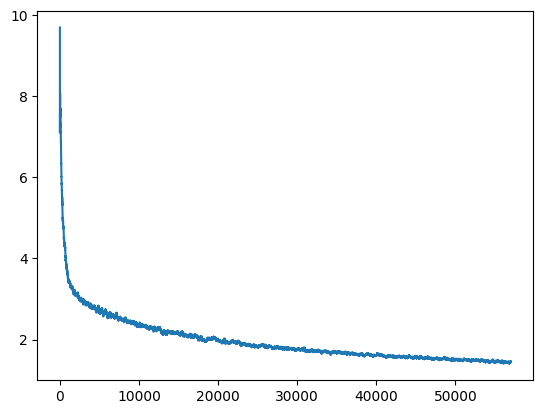

In [49]:
pd.Series(losses).ewm(100).mean().plot();

In [50]:
def translate(text, src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL, a=16, b=1.5, max_input_length=1024, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [51]:
xx, yy, lang1, lang2 = get_batch_pairs(1, data=df_dev)
print(xx)
print(yy)
model.eval()
print(translate(xx[0], lang1, lang2, no_repeat_ngram_size=3, num_beams=5))

['Chayna waqaychawananchikpi iñiyninchikqa allinpunim kanqa salvakunapaq hinaspa hinalla Diosman sonqo kanapaq (Joel 2: 31, 32).']
['La fe en que Jehová nos protegerá durante su día "grande e inspirador de temor " nos permitirá" [ver] la salvación de Jehová " y así mantenernos leales.']
['La fe en esa protección será imprescindible para nuestra salvación y nuestra lealtad.']


In [52]:
!ls -alsh $MODEL_SAVE_PATH

total 2.4G
4.0K drwxrwxr-x  2 americasnlp americasnlp 4.0K Mar  9 15:29 .
4.0K drwxr-xr-x 10 americasnlp americasnlp 4.0K Mar  9 15:35 ..
 22M -rw-rw-r--  1 americasnlp americasnlp  22M Mar  9 15:22 all_texts_file.csv
4.0K -rw-rw-r--  1 americasnlp americasnlp  896 Mar  9 21:10 config.json
4.0K -rw-rw-r--  1 americasnlp americasnlp  184 Mar  9 21:10 generation_config.json
2.4G -rw-rw-r--  1 americasnlp americasnlp 2.4G Mar  9 21:10 pytorch_model.bin
4.8M -rw-rw-r--  1 americasnlp americasnlp 4.8M Mar  9 21:10 sentencepiece.bpe.model
4.0K -rw-rw-r--  1 americasnlp americasnlp 3.5K Mar  9 21:10 special_tokens_map.json
384K -rw-rw-r--  1 americasnlp americasnlp 382K Mar  9 15:22 spm_16k.model
160K -rw-rw-r--  1 americasnlp americasnlp 157K Mar  9 15:22 spm_16k.vocab
4.8M -rw-rw-r--  1 americasnlp americasnlp 4.8M Mar  9 15:22 spm_nllb_268k.model
4.0K -rw-rw-r--  1 americasnlp americasnlp  570 Mar  9 21:10 tokenizer_config.json


<h1 id="7.-Using-the-model">7. Testing the model</h1>

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig
from tqdm.auto import tqdm, trange

In [54]:
def fix_tokenizer(tokenizer, new_lang=LANGUAGE_TARGET_LABEL):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [55]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_SAVE_PATH).cuda(CUDA_CORE)
tokenizer = NllbTokenizer.from_pretrained(MODEL_SAVE_PATH)
fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [56]:
def translate(text, src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL, a=32, b=3, max_input_length=1024, num_beams=4, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams,
        **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [57]:
t = "las canciones de amor me gustan mucho"
print(translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL))

['Kuyakuymanta takikunam ñuqapaqqa aswan gustan']


In [58]:
translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL, do_sample=True, num_beams=1, temperature=1.5)

['Icha kuyaymanta takikunam kusichiwan']

In [59]:
t = "kuyakuyllawan takitam anchata kuyani"
print(translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL))

['Me encantan las canciones con melodía.']


In [60]:
translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL, do_sample=True, num_beams=1, temperature=1.5)

['La toalla del cine es más que mi sueño a diario']

In [61]:
def batched_translate(texts, batch_size=8, **kwargs):
    """Translate texts in batches of similar length"""
    idxs, texts2 = zip(*sorted(enumerate(texts), key=lambda p: len(p[1]), reverse=True))
    results = []
    for i in trange(0, len(texts2), batch_size):
        results.extend(translate(texts2[i: i+batch_size], **kwargs))
    return [p for i, p in sorted(zip(idxs, results))]

In [62]:
# df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'] = batched_translate(df_test["LANGUAGE_FILE_TARGET_LABEL"], src_lang=LANGUAGE_TARGET_LABEL, tgt_lang=LANGUAGE_ORIGIN_LABEL)
# df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'] = batched_translate(df_test["LANGUAGE_FILE_ORIGIN_LABEL"], src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL)

In [63]:
df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'] = [translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL)[0] for t in tqdm(df_test[LANGUAGE_FILE_TARGET_LABEL])]
df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'] = [translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL)[0] for t in tqdm(df_test[LANGUAGE_FILE_ORIGIN_LABEL])]

  0%|          | 0/24976 [00:00<?, ?it/s]

  0%|          | 0/24976 [00:00<?, ?it/s]

In [64]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

In [65]:
print(bleu_calc.corpus_score(df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]))
print(chrf_calc.corpus_score(df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]))
print(bleu_calc.corpus_score(df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_TARGET_LABEL].tolist()]))
print(chrf_calc.corpus_score(df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_TARGET_LABEL].tolist()]))

BLEU = 19.26 47.7/24.3/16.2/11.3 (BP = 0.898 ratio = 0.903 hyp_len = 403768 ref_len = 447315)
chrF2++ = 37.42
BLEU = 9.16 33.8/11.8/6.6/4.4 (BP = 0.885 ratio = 0.891 hyp_len = 265408 ref_len = 297933)
chrF2++ = 36.65


In [66]:
pd.options.display.max_colwidth = 100

In [67]:
df_test.sample(10, random_state=42)[[LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_FILE_TARGET_LABEL + '_translated', LANGUAGE_FILE_ORIGIN_LABEL + '_translated']]

,quechua,esp,quechua_translated,esp_translated
12982,Necesitasqallaykichikpi gastaychik.,Hagan cambios.,Imapipas cambiaychik.,Dedíquense a cubrir sus necesidades básicas.
36270,‘ Huk ratollapi ’ nisqanmi qawachin puchukaynin mana unay tiempopi kananmanta.,La expresión “en una sola hora ” muestra que su destrucción será relativamente rápida.,Huk horallapi kasqankum qawachin satanaspa puchukaynin chaylla kananmanta.,Las palabras de una oración en lenguaje sencillo indican que el fin está muy cerca.
77931,"Bardet runapa nisqanman hinaqa, Cristo sutiqa allintapunim tupan griego rimaypi qellqasqa kasqan...","En su análisis, Bardet declara que ese título concuerda “en todo sentido con el idioma griego, q...","Bardet sutiyoq runam qellqasqanpi nin: ""Chay sutiqa tupashanmi griego rimaypi kaq sutikunawan, c...",Bardet explica que el nombre Cristo encaja muy bien con el texto griego original.
156122,Kallpachawananchismi allin kaqta ruwanapaq allin runa kananchispaqpas.,"Además, debe sacar lo mejor de cada uno de nosotros y darnos fuerzas para hacer lo que está bien.",Hinaspapas sapankanchistan kallpachashan allin kaqkunata ruwananchispaq.,Tiene que motivarnos a hacer lo correcto y a cultivar cualidades cristianas.
119112,Chay mozoñataqmi iñiqmasinchikta nirqa paywan rimayta mana munasqanmanta.,El joven le dijo que no quería hablar con él.,Chay waynañataqmi nirqa paywan mana rimayta munasqanta.,El joven le dijo a la hermana que no quería hablar con él.
140928,• ¿Imataq ‘ llamp’u sonqo ’ kayri?,• ¿Qué significa ser “de genio apacible ”?,• ¿Ima ninantaq llampu sonqo kayqa?,• ¿Qué es la apacibilidad y la modestia?
45324,Chayna mañakuymi qawachin ñoqanchikmantawan hukkunamanta ima piensasqanchikta.,Ese tipo de oraciones revelan mucho sobre nosotros y sobre la manera en que vemos a los hermanos.,Chayna mañakusqanchikmi qawachiwanchik imayna kasqanchikta hinaspa iñiqmasinchikkunata imayna qa...,Este tipo de oración revela lo que pensamos de nosotros y de los demás.
210637,"Arí, umallikunaqa ‘ michiwashallanchispunin ’ (otaq ‘ mana puñuspa almanchista qhawashanku ’, Qh...",Los ancianos están “velando por las almas ” de sus hermanos.,Congregacionpi ancianokunaqa iñiqmasinkunapa sonqonmantam cuentallikuchkanku.,"En efecto, los superintendentes cristianos siempre están pendientes de nuestro bienestar espirit..."
193954,Ichaqa iskay semana apachisqanku qhepamanmi llapanta kutichipusqaku.,"Sin embargo, dos semanas después, el envío entero regresó a la Casa Bíblica.",Ichaqa iskay semana qhepamanmi chay qelqakuna hunt'a karqan Bibliamanta Yachana Wasiman.,"Sin embargo, las dos semanas más tardas, el dinero se les devolvió en su totalidad."
131759,nispa pipas tapuykuqtinmi ninku: “Tayta - mamaymi chayta yachachiwaranku ” otaq“ chhaynatan yach...,"Pero si se le preguntara por qué cree en él, tal vez respondería que así lo criaron o que eso fu...","Sichus tapusunkiman imarayku paypi iñisqaykimanta chayqa, yaqapaschá niwaq: ""Chhaynapin uywasqa ...","Cuando alguien les pregunta si es cierto o no, ellos responden que sus padres nos enseñaron a ha..."
